# Bike rental

This notebook is part of Alura's courses [Deep Learning: previsão com Keras) (Deep Learning: predictions with Keras)](https://cursos.alura.com.br/course/deep-learning-previsao-keras) by Allan Segovia Spadini.

All the code was written in Python 3, using Google Colab.

**For more info, check the README.**

--- 

# EDA 

In [2]:
# Importing libraries

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, LSTM

#from utils.processing import lagged_data

In [ ]:
def lagged_data(vector, lag):
    """Generate lagged data 

    Args:
        vector (arr): array with numerical data
        lag (int): number of lag

    Returns:
        array: arrays with lagged data
    """
    X_lag, y_lag = [], []
    for i in range(lag,vector.shape[0]):
      X_lag.append(list(vector.loc[i-lag:i-1]))
      y_lag.append(vector.loc[i])
    X_lag, y_lag = np.array(X_lag), np.array(y_lag) 
    return X_lag, y_lag


def plot_timeseries(x, y1, y2, data1, data2, label1, label2, xlabel,
                    ylabel, title, marker=None):
    sns.lineplot(
        x=x,
        y=y1,
        data=data1,
        label=label1
    )
    sns.lineplot(
        x=x,
        y=y2,
        data=data2,
        label=label2,
        marker=marker
    )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=70)
    plt.show()


In [ ]:
# Setting plot parameters

mpl.rcParams["figure.figsize"] = (10,6)
mpl.rcParams["font.size"] = 15

In [5]:
# Importing the data set

bike = pd.read_csv("data/bike_rental.csv")

In [6]:
# Displaying the first five rows

#bike.head()

,date,count,temperature,thermal_sensation,humidity,wind_speed,climate,holiday,weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [7]:
# Displaying the shape

bike.shape

(17414, 10)

In [8]:
# Checking for null values

bike.isna().sum()

date                 0
count                0
temperature          0
thermal_sensation    0
humidity             0
wind_speed           0
climate              0
holiday              0
weekend              0
season               0
dtype: int64

In [9]:
# Checking the data types

bike.dtypes

date                  object
count                  int64
temperature          float64
thermal_sensation    float64
humidity             float64
wind_speed           float64
climate              float64
holiday              float64
weekend              float64
season               float64
dtype: object

In [10]:
# Displaying the main statistics

#bike.describe()

,count,temperature,thermal_sensation,humidity,wind_speed,climate,holiday,weekend,season
count,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000
mean,1143.101642,12.468091,11.520836,72.324954,15.913063,2.722752,0.022051,0.285403,1.492075
std,1085.108068,5.571818,6.615145,14.313186,7.894570,2.341163,0.146854,0.451619,1.118911
min,0.000000,-1.500000,-6.000000,20.500000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,257.000000,8.000000,6.000000,63.000000,10.000000,1.000000,0.000000,0.000000,0.000000
50%,844.000000,12.500000,12.500000,74.500000,15.000000,2.000000,0.000000,0.000000,1.000000
75%,1671.750000,16.000000,16.000000,83.000000,20.500000,3.000000,0.000000,1.000000,2.000000
max,7860.000000,34.000000,34.000000,100.000000,56.500000,26.000000,1.000000,1.000000,3.000000


In [11]:
# Displaying the date range

print("First datetime registered: ", min(bike["date"]))
print("Last datetime registered: ", max(bike["date"]))

First datetime registered:  2015-01-04 00:00:00
Last datetime registered:  2017-01-03 23:00:00


There aren't any missing values, and we can see that there are around 17000 records and 10 columns, most of them numerical and boolean. 

Also, the data set has over 17000 records and 10 features covering two entire years, there are no missing values, and the data types are correct, except for the date column, which was labeled as an object instead of date time. Let's convert it.

In [12]:
# Converting the date column to datetime

bike["date"] = pd.to_datetime(bike["date"])

To predict the number of bikes rented, it is necessary only two columns: date and count. Let's see the distribution of rented bikes over time.

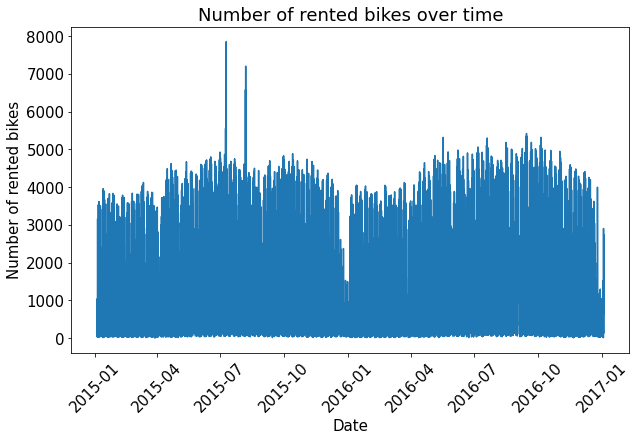

In [13]:
# Plotting the number of rented bikes over time
plt.figure(figsize=(10,6))
sns.lineplot(x="date", y="count", data=bike)
plt.xlabel("Date")
plt.ylabel("Number of rented bikes")
plt.title("Number of rented bikes over time")
plt.xticks(rotation=45)
plt.show()

The line plot above shows us that the number of bikes rented decreases in December. This could be related to the holiday season when people used to travel or spend more time at home. Also, there are two clear peaks between July and August 2015 which hit almost double the normal demand. 

Now it is necessary to standardize the data, removing the mean and scaling to unit variance to use them in the model.

In [14]:
# Instantiating the StandardScaler

sc = StandardScaler()

In [15]:
# Fitting and scaling the data

sc.fit(bike["count"].values.reshape(-1,1))
X = sc.transform(bike["count"].values.reshape(-1,1))

Let's split the data set into train and test sets.

In [16]:
# Splitting the data into training and test sets

training_size = int(len(bike)*0.9)

X_train = X[0:training_size]
X_test = X[training_size:len(bike)]

Let's plot the train and test sets.

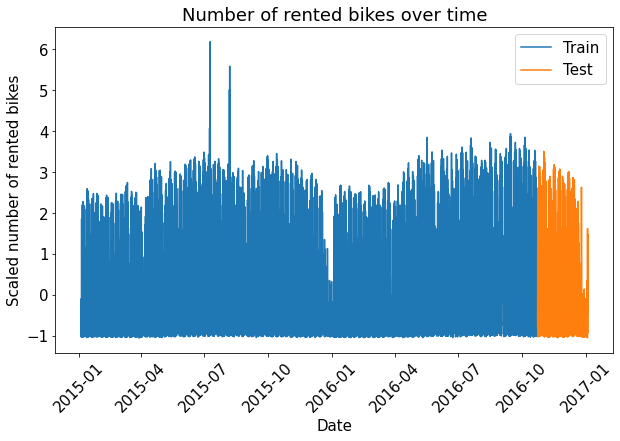

In [17]:
# Plotting the train and test sets

plt.figure(figsize=(10,6))
sns.lineplot(x="date", y=X_train[:,0], data=bike[0:training_size], label = "Train")
sns.lineplot(x="date", y=X_test[:,0], data=bike[training_size:len(bike)], label = "Test")
plt.xlabel("Date")
plt.ylabel("Scaled number of rented bikes")
plt.title("Number of rented bikes over time")
plt.xticks(rotation=45)
plt.show()

To predict the number of bikes rented, let's use the count of a specific day to predict the number of bikes on the following day. 

For this task, the input data will be the original data, and the output (or the predicted values) will be the number of passengers the following day. Thus, we need to create a lag in the number of passengers numbers.

In [18]:
# Lagging the train and test sets

X_train_df = pd.DataFrame(X_train)[0]
X_test_df = pd.DataFrame(X_test)[0]

In [19]:
# Splitting the data into X and y

X_train_lag, y_train_lag = lagged_data(X_train_df, 10)
X_test_lag, y_test_lag = lagged_data(X_test_df , 10)

To predict time series outputs, the traditional neural network does not deliver the best model. In this case, we want to use more than one data point to predict the outcome. For example, in the stock market, the price of the company share is determined based on yesterday's closing price, which was based on the day before the last number, and so on. So the past data is not negligible, and the more recent the data, the more relevant it is for the model. Thus yesterday's price is more important than 10 days ago's price. 

To overcome this problem, we will use the recurrent neural network which is similar to the traditional neural network. The main difference is the feedback loop that allows the model to handle two sequential inputs at the same time. This loop has a weight ($w_{f}$) as any other cell in the network but it never changes. And it is a problem for the gradient descent. If $w_{f}$ is bigger than 1 then the gradient will explode (for example, $2^{50}$ if $w_{f}$ = 2 for 50 inputs) and if it is lower than 1, the gradient will vanish (for example $0.5^{50}$).

That brings us to Long Short-Term Memory (LSTM).

--- 

# Long-short term memory (LSTM)

The Long Short Term Memory (LSTM) is based on recurrent neural networks (RNN) that avoid the vanishing/exploding gradient descent by using two different paths for the prediction: the long-term memory (Cell state), which does not carry any weight or bias; on the other hand the short-term memory (hidden state), which is the traditional RNN, is, of course, associated with biases and weights.

This technique uses two activation functions: the sigmoid function and the hyperbolic tangent (tanh). The former is defined by:

$S(x) = \frac{e^{x}}{e^{x}+1}$. 

This function always returns values between 0 and 1. The latter is defined by

$tanh(x) = \frac{sinh(x)}{cosh(x)} = \frac{e^{2x}-1}{e^{2x}+1}$. 

Unlike the sigmoid function, the tanh always returns values between -1 and 1.

The LSTM is divided into units. The first one is called **forget gate**. and it represents the percentage of long-term memory that is remembered. For example, if x = 1 then S(1) = 0.73, or 73% of the long-term memory will still be memorized.

The second unit uses (also known as **input gate**) a combination between the sigmoid and the hyperbolic tangent. The latter plays the role of potential long-term memory (PLTM), and the former is still the percentage of this PLTM that will be added the to cell state.

The final unit (the output gate) is a combination of, likewise the input gate, sigmoid, and tanh functions. This time, the potential long-term memory comes from the cell state, and the input for the percentage of potential memory to remember comes from the short-term memory. In this unit, we multiply the outcomes from both activation functions to get the output for the new short-term memory.

## Glorot Uniform (Xavier Initialization)

Glorot uniform (also called Xavier normal initializer) is a weight initialization of neural networks which generates random weight values based on gaussian distribution with mean = 0 and stddev = $\frac{\sqrt{2}}{{u_{in}+{u_{out}}}}$, i.e., each layer will be a different weights initialization depending on the number of input and output units.

## RMSprop optimizer

RMSprop (Root Mean Squared Propagation) optimizer is similar to gradient descent with momentum, which, in both cases, reduces the number of steps in one axis, and the axis remaining can take larger steps towards the global minimum, i.e., it enables the model to converge faster. The main difference between them is the way the gradient is calculated and, for RMSprop, is defined by:

$v_{t} = β̇⋅v_{t-1} + (1-\beta)\cdot(\frac{\partial C}{\partial w})^{2}$

$W_{t} = W_{t-1} - \frac{\alpha}{v_{t}}\frac{\partial C}{\partial W}$, 

onde $v$ = gradient descendent, $\beta = moving average parameter$, $\frac{\partial C}{\partial w}$ = gradient of the cost function with respect to the weight, W = weight, and $α$ = learning rate.

In [20]:
# Reshaping the input data to include a third dimension

X_train_lag = X_train_lag.reshape((X_train_lag.shape[0], X_train_lag.shape[1], 1))
X_test_lag = X_test_lag.reshape((X_test_lag.shape[0], X_test_lag.shape[1], 1))

Let's build the LSTM model.

In [21]:
# Building the LSTM model

lstm_model = Sequential()

lstm_model.add(LSTM(128,
                      input_shape=(X_train_lag.shape[1], X_train_lag.shape[2]))
)
lstm_model.add(Dense(units=1))

lstm_model.compile(loss="mean_squared_error", optimizer="RMSProp")

In [ ]:
# Fitting the model

result_lstm = lstm_model.fit(X_train_lag,
               y_train_lag,
               validation_data=(X_test_lag, y_test_lag),
               epochs=5
)

In [23]:
# Prediction

y_pred_train = lstm_model.predict(X_train_lag)
y_pred_test = lstm_model.predict(X_test_lag)

55/55 [==============================] - 0s 6ms/step


The model is already trained and predicts the values for the training set. Let's plot the original data and the prediction.

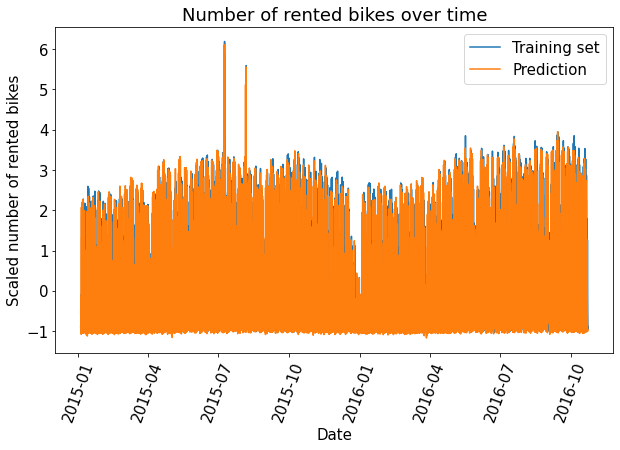

In [24]:
# Plotting the the training set's prediction

plt.figure(figsize=(10,6))
sns.lineplot(x="date",
             y=X_train[:,0],
             data=bike[0:training_size],
             label="Training set")
sns.lineplot(x="date",y=y_pred_train[:,0],data=bike[0:15662],label="Prediction")
plt.xlabel("Date")
plt.ylabel("Scaled number of rented bikes")
plt.title("Number of rented bikes over time")
plt.xticks(rotation=70) 
plt.show()

Let's scale back the predictions and the test set to the whole graphic makes sense.

In [44]:
# Scalling back

y_pred_test_inv = sc.inverse_transform(y_pred_test)
X_test_inv = sc.inverse_transform(X_test)

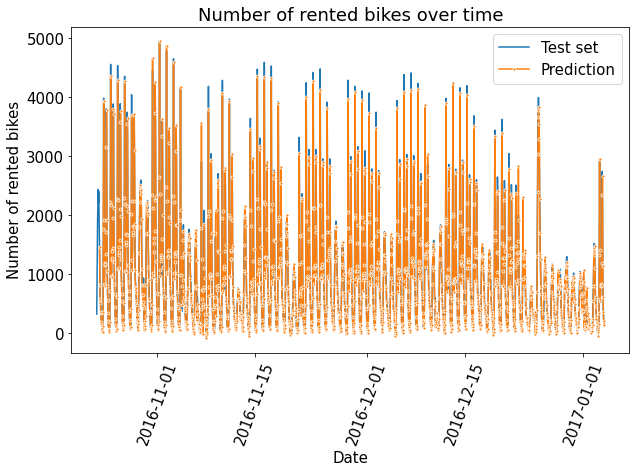

In [46]:
# Plotting the test set's predictions

plt.figure(figsize=(10,6))
sns.lineplot(x="date",
             y=X_test_inv[:,0],
             data=bike[training_size:len(bike)],
             label="Test set"
)
sns.lineplot(x="date",
             y=y_pred_test_inv[:,0],
             data=bike[training_size+10:len(bike)],
             marker=".",
             label="Prediction"
)
plt.xlabel("Date")
plt.ylabel("Number of rented bikes")
plt.title("Number of rented bikes over time")
plt.xticks(rotation=70) 
plt.show()

--- 

## GRU


The GRU, Gated Recurrent Unit, is similar to LSTM but it does not have the cell state, and it has two gates, the reset gate, i.e., how much of the hidden state term is conserved or remembered, and the update gate that updates the value for the hidden state to be used in another unit.

For the reset gate, it passes the input number to its weight and bias and it is fed into the sigmoid function and then added to the hidden state value. Since the sigmoid function outputs are limited between 0 and 1, it could be interpreted as the percentage of the hidden layer that is kept in the model. Finally, this term is added to the input and then passes through the tanh function to compose the new value in the hidden state.

The update gate takes the combined value from the hidden state and the input and it passes through the sigmoid function, and its output is multiplied by the tanh output. Also, update gate output is subtracted by 1 (1-output) and then multiplied to the original hidden state value and finally, this value is added with the tanh output value to form the new hidden state number to be used in the next unit. 

Now let's build a model using GRU and compare it to the LSTM.

In [28]:
# Building the GRU model

gru_model = Sequential()

gru_model.add(GRU(128, input_shape=(X_train_lag.shape[1],X_train_lag.shape[2])))
gru_model.add(Dense(units=1))

gru_model.compile(loss='mean_squared_error',optimizer='RMSProp')

Since the GRU has fewer parameters to be trained than LSTM, this model should run faster. Let's train and test the model.

In [ ]:
# Fitting and predicting the GRU model 

result_gru = gru_model.fit(X_train_lag,
              y_train_lag,
              validation_data=(X_test_lag,y_test_lag),
              epochs=5
)

y_pred_gru = gru_model.predict(X_test_lag)

Again, let's scale back the model predictions.

In [42]:
# Invesing the standard scaling

y_pred_gru_inv = sc.inverse_transform(y_pred_gru)

Now, let's check the original data and the predictions for the test data.

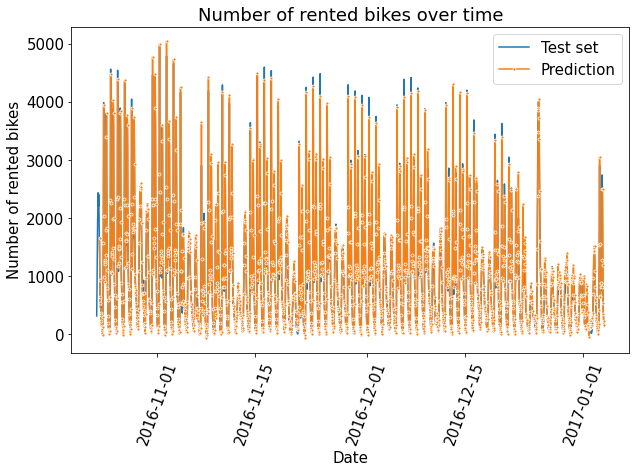

In [43]:
# Plotting the test set's predictions for the GRU model

plt.figure(figsize=(10,6))
sns.lineplot(x="date",
             y=X_test_inv[:,0],
             data=bike[training_size:len(bike)],
             label="Test set"
)
sns.lineplot(x="date",
             y=y_pred_gru_inv[:,0],
             data=bike[training_size+10:len(bike)],
             marker=".",
             label="Prediction"
)
plt.xlabel("Date")
plt.ylabel("Number of rented bikes")
plt.title("Number of rented bikes over time")
plt.xticks(rotation=70) 
plt.show()

Both LSTM and GRU had similar results predicting the number of rental bikes. But which one was the best? 

Let's compare the loss and validation loss for both models.

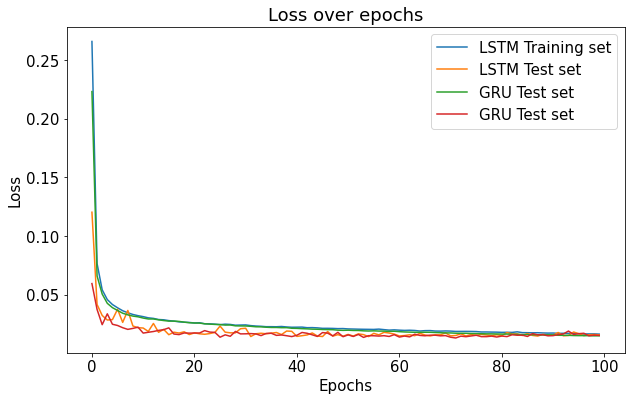

In [36]:
# Plotting the loss and validation loss over epochs of LSTM and GRU models

plt.figure(figsize=(10,6))
plt.plot(result_lstm.history['loss'], label = "LSTM Training set")
plt.plot(result_lstm.history['val_loss'], label = "LSTM Test set")
plt.plot(result_gru.history['loss'], label = "GRU Test set")
plt.plot(result_gru.history['val_loss'], label = "GRU Test set")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over epochs")
plt.legend()
plt.show()

For both LSTM and GRU training and test sets, the loss starts high and then decreases over epochs which is good. In this case, the overfitting would happen if the loss curve for the test set was above the training one.  

Finally, since all the curves are similar over 100 epochs, I will choose the GRU model due to the speed of neural network processing. Using it, we can have good results by spending less time and resources.

--- 

# Recomendations

Looking at the number of bike rent predictions using GRU, we see that November and December will have a slight decrease in the number of bikes rented, and a severe drop in rents due to the holiday season. People probably will be traveling on Christmas and New Year's Eve, and they will be back to school, college, and/or work in early January, the model could predict that as well. The company should save money before November to not be in debt in the last couple of months of the year, especially December.

---